In [9]:
import os
import zipfile
import urllib.request
import torch
from torch import nn, optim
import numpy as np
import scipy
from scipy.io import loadmat 
import math
from matplotlib import pyplot as plt

import deepSI
from deepSI import System_data, System_data_list
from deepSI.utils import simple_res_net
from deepSI.utils import feed_forward_nn
from deepSI.utils import fit_with_early_stopping
from deepSI.utils import integrator_RK4, integrator_euler
from deepSI.utils.torch_nets import time_integrators
from deepSI.fit_systems import SS_encoder_deriv_general
from deepSI.fit_systems.encoders import SS_encoder_general_hf, default_encoder_net, hf_net_default

In [31]:
###Loading the benchmark data: Cascaded Tanks with Overflow
#https://www.nonlinearbenchmark.org/benchmarks/cascaded-tanks

def find_mat_file(directory):
    """Search for the .mat file inside extracted directories."""
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".mat"):
                return os.path.join(root, file)
    return None

def Cascaded_Tanks(dir_placement=None, force_download=False, split_data=True):
    """Downloads, extracts, and loads the Cascaded Tanks dataset."""
    url = 'https://data.4tu.nl/file/d4810b78-6cdd-48fe-8950-9bd601e5f47f/3b697e42-01a4-4979-a370-813a456c36f5'
    base_dir = os.path.expanduser("~/.deepSI/data_sets/Cascaded_Tanks")
    zip_path = os.path.join(base_dir, "CascadedTanksFiles.zip")
    extract_dir = os.path.join(base_dir, "CascadedTanksFiles")

    # Ensure base directory exists
    os.makedirs(base_dir, exist_ok=True)

    # Download the dataset if necessary
    if force_download or not os.path.exists(zip_path):
        print(f"Downloading dataset from {url} ...")
        urllib.request.urlretrieve(url, zip_path)
        print(f"Downloaded to {zip_path}")

    # Extract ZIP file
    if not os.path.exists(extract_dir):
        print(f"Extracting {zip_path} to {extract_dir} ...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("Extraction complete.")

    # Find the .mat file
    mat_file = find_mat_file(extract_dir)
    if mat_file is None:
        raise FileNotFoundError(f"No .mat file found in {extract_dir}")

    print(f"Loading data from {mat_file} ...")

    # Load the dataset
    out = loadmat(mat_file)
    uEst, uVal, yEst, yVal, Ts = (
        out["uEst"][:, 0], out["uVal"][:, 0],
        out["yEst"][:, 0], out["yVal"][:, 0],
        out["Ts"][0, 0]
    )

    # Convert to deepSI System_data format
    datasets = [deepSI.System_data(u=uEst, y=yEst), deepSI.System_data(u=uVal, y=yVal)]
    datasets = deepSI.System_data_list(datasets)

    return datasets if not split_data else (datasets.sdl[0], datasets.sdl[1])

# Run the function
data = Cascaded_Tanks(force_download=True)

Downloaded to /home/sarvin/.deepSI/data_sets/Cascaded_Tanks/CascadedTanksFiles.zip
Loading data from /home/sarvin/.deepSI/data_sets/Cascaded_Tanks/CascadedTanksFiles/CascadedTanksFiles/dataBenchmark.mat ...


Loading data from /home/sarvin/.deepSI/data_sets/Cascaded_Tanks/CascadedTanksFiles/CascadedTanksFiles/dataBenchmark.mat ...


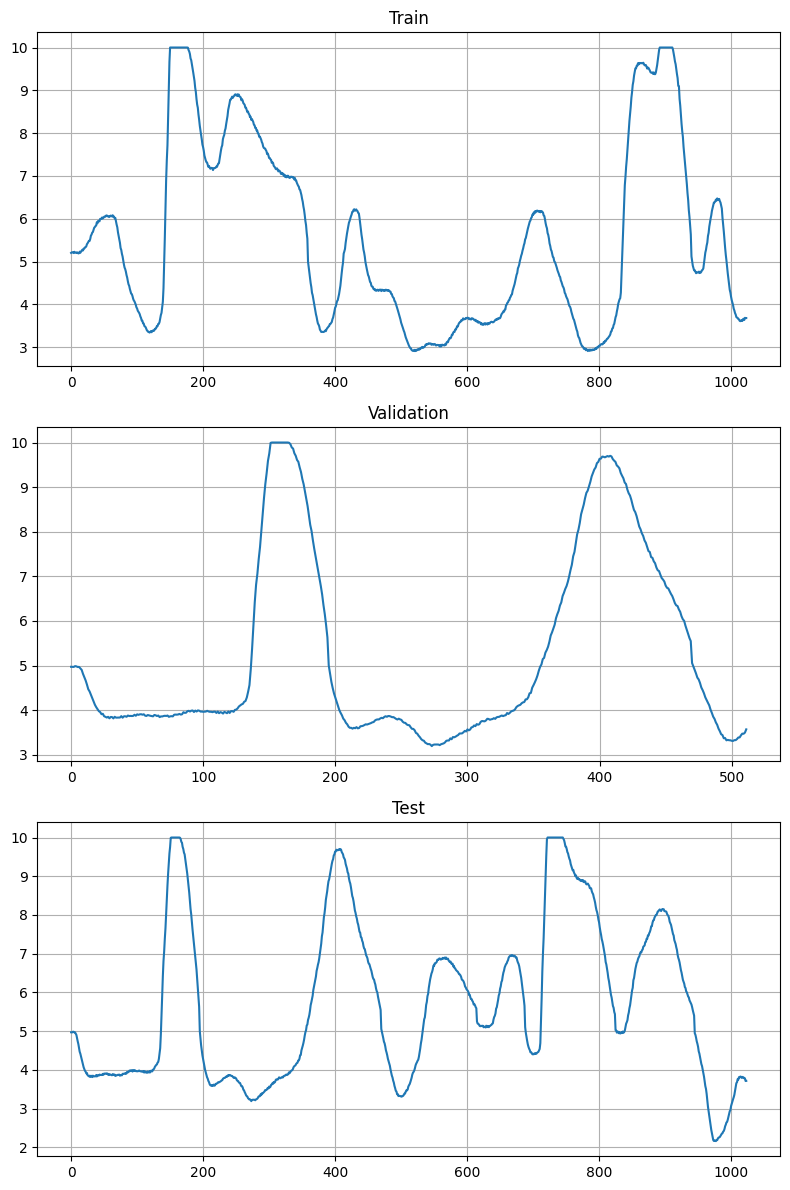

In [3]:
# Load and prepare data
def load_data():
    train_data, test_data = Cascaded_Tanks(force_download=False)
    return System_data(u=train_data.u, y=train_data.y), \
           System_data(u=test_data.u[:512], y=test_data.y[:512]), \
           System_data(u=test_data.u, y=test_data.y)

train, val, test = load_data()
#t_s_original = 4
t_s = 0.04 
for dataset in [train, val, test]:
    dataset.dt = t_s
    dataset.u, dataset.y = dataset.u.reshape(-1, 1), dataset.y.reshape(-1, 1)

# Plot data
def plot_data(train, val, test):
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))
    for ax, data, title in zip(axes, [train, val, test], ['Train', 'Validation', 'Test']):
        ax.set_title(title)
        ax.plot(data.y)
        ax.grid()
    plt.tight_layout()
    plt.show()

plot_data(train, val, test)


In [4]:
# Variables and settings

# system structure settings and initialization
nx = 2    # number of states
nb = 4    # encoder past inputs
na = 4    # encoder past outputs
nf = 60  #T or futur steps in encoder

batch_size = 64 #
#epochs_per_early_stopping_check = 300 #minimum epochs

In [13]:
#Neural networks: definition of J(x), R(x), H(x)
#choose boolean for constant/state_dependant matrices: constant+boolean*state_dependant

net_kwargs = {'n_nodes_per_layer': 8, 'n_hidden_layers': 1}
net_kwargs_G = {'n_nodes_per_layer': 8, 'n_hidden_layers': 1}
net_kwargs_H = {'n_nodes_per_layer': 8, 'n_hidden_layers': 1}


class Matrix_net(nn.Module):
    # A(x) 
    # A = (Nbatch, n, ncols) if ncols is not given (Nbatch, n, ncols)
    # x = (Nbatch, nx)
    ## Normalized matrix by factor 1/sqrt(ncols) if norm='auto' else *norm will be done
    ## net is called as net(n_in=nx, n_out=n*ncols,**net_kwargs)
    def __init__(self, nx, n, ncols=None, net=feed_forward_nn, net_kwargs={}, norm='auto'):
        super().__init__()
        self.nx = nx
        self.n = n
        self.ncols = ncols if ncols is not None else n
        self.net = net(n_in=nx, n_out=n*self.ncols, **net_kwargs)
        if norm == 'auto':
            self.norm = 1/self.ncols**0.5 if self.ncols>0 else 1
        else:
            self.norm = norm
    
    def forward(self, x):
        return self.net(x).view(x.shape[0], self.n, self.ncols)*self.norm
    
    
class Matrix_res_net(nn.Module):
    # A(x) 
    # A = (Nbatch, n, ncols) if ncols is not given (Nbatch, n, ncols)
    # x = (Nbatch, nx)
    ## Normalized matrix by factor 1/sqrt(ncols) if norm='auto' else *norm will be done
    ## net is called as net(n_in=nx, n_out=n*ncols,**net_kwargs)
    def __init__(self, nx, n, ncols=None, net=simple_res_net, net_kwargs={}, norm='auto'):
        super().__init__()
        self.nx = nx
        self.n = n
        self.ncols = ncols if ncols is not None else n
        self.net = net(n_in=nx, n_out=n*self.ncols, **net_kwargs)
        if norm == 'auto':
            self.norm = 1/self.ncols**0.5 if self.ncols>0 else 1
        else:
            self.norm = norm
    
    def forward(self, x):
        return self.net(x).view(x.shape[0], self.n, self.ncols)*self.norm
    
    

class Sym_pos_semidef_matrix_net(nn.Module):
    def __init__(self, nx, n, net=feed_forward_nn, net_kwargs={}, norm='auto', mode='nonlinear'):
        super().__init__()
        if norm == 'auto':
            norm = 1 / ((2 + n) * n) ** 0.25 if n > 0 else 1
        self.mat_net = Matrix_net(nx, n, net=net, net_kwargs=net_kwargs, norm=norm)
        self.mode = mode  # Mode: 'nonlinear', 'constant', 'combined'
        self.R_param = nn.Parameter(torch.randn(n, n))  # Learnable parameter

    def forward(self, x):
        A = self.mat_net(x)
        
        # Compute nonlinear part if mode is 'nonlinear' or 'combined'
        R_nn = torch.einsum('bik,bjk->bij', A, A) if self.mode in ['nonlinear', 'combined'] else torch.zeros_like(A)
        
        # Compute constant part if mode is 'constant' or 'combined'
        R_param = torch.mm(self.R_param, self.R_param.t()) if self.mode in ['constant', 'combined'] else torch.zeros_like(self.R_param)
        
        # Combine R_param and R_nn based on mode
        R = R_param + R_nn
        
        return R


class Skew_sym_matrix_net(nn.Module):
    def __init__(self, nx, n, net=feed_forward_nn, net_kwargs={}, norm='auto', mode='nonlinear'):
        super().__init__()
        if norm == 'auto':
            norm = 1 / ((2 + n) * n) ** 0.25 if n > 0 else 1
        self.mat_net = Matrix_net(nx, n, net=net, net_kwargs=net_kwargs, norm=norm)
        self.mode = mode  # Mode: 'nonlinear', 'constant', 'combined'
        self.J_param = nn.Parameter(torch.randn(n, n))  # Learnable parameter

    def forward(self, x):
        A = self.mat_net(x)
        
        # Compute nonlinear part if mode is 'nonlinear' or 'combined'
        J_nn = A - A.permute(0, 2, 1) if self.mode in ['nonlinear', 'combined'] else torch.zeros_like(A)
        
        # Compute constant part if mode is 'constant' or 'combined'
        J_param_skew = self.J_param - self.J_param.t() if self.mode in ['constant', 'combined'] else torch.zeros_like(self.J_param)
        
        # Combine J_param and J_nn based on mode
        J = J_param_skew + J_nn
        
        return J

    
# Hamiltonian with lower bound
class Lower_bounded_nets(nn.Module):
    def __init__(self, n_in, n_out, lower_bound=0, net=feed_forward_nn, net_kwargs={}):
        super(Lower_bounded_nets, self).__init__()
        self.net = net(n_in, n_out, **net_kwargs)
        self.lower_bound = lower_bound
        
    def forward(self, x):
        y = self.net(x)
        # elu[y - (lower_bound + 1)] + (lower_bound + 1)
        b = self.lower_bound + 1
        return torch.nn.functional.elu(y - b) + b

# Hamiltonian with quadratic node
class HamiltonianMatrixNet(nn.Module):
    def __init__(self, nx, n, net=feed_forward_nn, net_kwargs={}, norm='auto'):
        super(HamiltonianMatrixNet, self).__init__()
        self.boolean = True  # Initially set to False

        # Set up normalization factor
        if norm == 'auto':
            norm = 1 / ((2 + n) * n) ** 0.25 if n > 0 else 1
        self.norm = norm

        # Learnable symmetric positive semi-definite matrix
        self.H_param = nn.Parameter(torch.randn(n, n))

        # Feed-forward neural network
        self.feedforward_nn = net(nx, 1, **net_kwargs)  # Output a single scalar value

    def forward(self, x):
        # Ensure H_param is symmetric and positive semi-definite
        H_param = torch.mm(self.H_param, self.H_param.t())  # H_param * H_param^T ensures positive semi-definiteness
        
        # Compute the quadratic term: 0.5 * norm * x^T H_param x
        quadratic_term = 0.5 * self.norm * torch.einsum('bi,ij,bj->b', x, H_param, x)
        
        # Apply the feed-forward network
        nn_output = self.feedforward_nn(x).squeeze(-1)  # Feed-forward NN produces scalar output per batch
        
        # Combine terms based on the boolean flag
        if self.boolean:
            H = quadratic_term + nn_output
        else:
            H = quadratic_term  # H is a scalar by construction

        return H.unsqueeze(-1)  # Return H as (batch_size, 1)

In [14]:
#Neural networks: definition of final input-state-output port-Hamiltonian NN + encoder
def integrate_multi_step_RK4(deriv, dt, x, n_steps=1): #u constant on segment, zero-order hold
    #put here a for loop
    n = n_steps    
    for _ in range(n):
        k1 = dt/n*deriv(x) #t=0
        k2 = dt/n*deriv(x+k1/2) #t=dt/2
        k3 = dt/n*deriv(x+k2/2) #t=dt/2
        k4 = dt/n*deriv(x+k3) #t=dt
        x = x + (k1 + 2*k2 + 2*k3 + k4)/6
    return x

class SS_encoder_general_hf_deriv(SS_encoder_general_hf):
    @property
    def dt(self):
        return self._dt 
    @dt.setter
    def dt(self,dt):
        self._dt = dt
        self.hfn.dt = dt
        
    def __init__(self, nx=nx, na=na, nb=nb, feedthrough=False, \
                 hf_net=hf_net_default, hf_net_kwargs={}, \
                 e_net=default_encoder_net, e_net_kwargs={}, na_right=0, nb_right=0):

        super(SS_encoder_general_hf_deriv, self).__init__(nx=nx, nb=nb, na=na, na_right=na_right, nb_right=nb_right)
        
        self.e_net = e_net
        self.e_net_kwargs = e_net_kwargs
        self.hf_net = hf_net
        self.hf_net_kwargs = hf_net_kwargs
        self.feedthrough = feedthrough

    def init_nets(self, nu, ny): # a bit weird
        na_right = self.na_right if hasattr(self, 'na_right') else 0
        nb_right = self.nb_right if hasattr(self, 'nb_right') else 0
        self.encoder = self.e_net(nb=self.nb+nb_right, nu=nu, na=self.na+na_right, ny=ny, nx=self.nx, **self.e_net_kwargs)
        self.hfn = self.hf_net(nx=self.nx, nu=nu, ny=ny, **self.hf_net_kwargs)

    def loss(self, uhist, yhist, ufuture, yfuture, **Loss_kwargs):
        x = self.encoder(uhist, yhist) #initialize Nbatch number of states
        errors = []
        for y, u in zip(torch.transpose(yfuture, 0, 1), torch.transpose(ufuture, 0, 1)): #iterate over time
            yhat, x = self.hfn(x, u)
            errors.append(nn.functional.mse_loss(y, yhat)) #calculate error after taking n-steps
        return torch.mean(torch.stack(errors))

    def measure_act_multi(self, actions):
        actions = torch.tensor(np.array(actions), dtype=torch.float32) #(N,...)
        with torch.no_grad():
            y_predict, self.state = self.hfn(self.state, actions)
        return y_predict.numpy()
    


class hf_net_pHNN(nn.Module):
    def __init__(self, nx, nu, ny, feedthrough=False,\
                 Hnet=feed_forward_nn, Hnet_kwargs={}, \
                 Jnet=Skew_sym_matrix_net, Jnet_kwargs={}, 
                 Rnet=Sym_pos_semidef_matrix_net, Rnet_kwargs={},
                 Gnet=Matrix_res_net, Gnet_kwargs={}, \
                 integrator=integrate_multi_step_RK4, integrator_kwargs={}, dt=None):
        super(hf_net_pHNN, self).__init__()
        assert nu != None
        assert ny != None
        assert nu==ny
        self.nx = nx
        self.nu = nu
        self.ny = ny
        self.H = Hnet(nx,**Hnet_kwargs)
        self.J = Jnet(nx, n=nx, **Jnet_kwargs)
        self.R = Rnet(nx, n=nx, **Rnet_kwargs)
        self.G = Gnet(nx=nx, n=nx, ncols=nu, **Gnet_kwargs) # shape: (Nb, nx, nu)
        self.feedthrough = feedthrough
        self.integrator = integrator
        self.integrator_kwargs = integrator_kwargs
        self.dt = dt
        
    def get_matricies(self, x):
        with torch.enable_grad():
            if x.requires_grad == False:
                x.requires_grad = True
            
            H = self.H(x)[:, 0]
            Hsum = H.sum()
            dHdx = torch.autograd.grad(Hsum, x, create_graph=True)[0]

        J_x = self.J(x)
        R_x = self.R(x)
        G_x = self.G(x)
        return J_x, R_x, G_x, dHdx, H
    
    
    def forward(self, x, u):
        J_x, R_x, G_x, dHdx, H = self.get_matricies(x)
        y_hat = torch.einsum('bij,bi->bj', G_x, dHdx) #bij,bi->bj  = A^T @ dHdx
        
        def f(xnow):
            J_x, R_x, G_x, dHdx, H = self.get_matricies(xnow)
            Gu = torch.einsum('bij,bj->bi',G_x, u.view(u.shape[0], -1)) # G_x (Nb, nx, nu) times u (Nb, nu) = (Nb, nx)
            return torch.einsum('bij,bj->bi', J_x - R_x, dHdx) + Gu
        
        x_next = self.integrator(f, self.dt, x, **self.integrator_kwargs)
        
        # Assuming ny is the output dimension of hn
        if self.feedthrough:
            y_hat = torch.cat([y_hat, u], dim=1)

        return y_hat, x_next

In [15]:
model = SS_encoder_general_hf_deriv(nx=nx, na=na, nb=nb,\
            hf_net=hf_net_pHNN)

model.fit(train,val,epochs=4000,batch_size=batch_size,loss_kwargs=dict(nf=nf))


Initilizing the model and optimizer
Size of the training array =  689.1 kB
N_training_samples = 980, batch_size = 64, N_batch_updates_per_epoch = 15
Initial Validation sim-NRMS= 1.0472951732979745


  0%|          | 1/4000 [00:12<13:42:40, 12.34s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 1.0350451212320662
Epoch    1, sqrt loss  0.9861, Val sim-NRMS  1.035, Time Loss: 79.3%, data: 0.0%, val: 20.6%,  1.2 batches/sec


  0%|          | 2/4000 [00:23<13:07:18, 11.82s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.8621547502097185
Epoch    2, sqrt loss  0.6395, Val sim-NRMS 0.8622, Time Loss: 81.2%, data: 0.0%, val: 18.8%,  1.3 batches/sec


  0%|          | 3/4000 [00:34<12:41:29, 11.43s/it]

Epoch    3, sqrt loss  0.5019, Val sim-NRMS 0.8749, Time Loss: 81.4%, data: 0.0%, val: 18.5%,  1.3 batches/sec


  0%|          | 4/4000 [00:45<12:28:55, 11.25s/it]

Epoch    4, sqrt loss  0.4407, Val sim-NRMS 0.9637, Time Loss: 81.6%, data: 0.0%, val: 18.3%,  1.3 batches/sec


  0%|          | 5/4000 [00:56<12:23:59, 11.17s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.709259947997507
Epoch    5, sqrt loss  0.3563, Val sim-NRMS 0.7093, Time Loss: 81.7%, data: 0.0%, val: 18.2%,  1.3 batches/sec


  0%|          | 6/4000 [01:08<12:30:47, 11.28s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.6110488395938113
Epoch    6, sqrt loss  0.3006, Val sim-NRMS  0.611, Time Loss: 81.6%, data: 0.0%, val: 18.3%,  1.3 batches/sec


  0%|          | 7/4000 [01:19<12:25:47, 11.21s/it]

Epoch    7, sqrt loss  0.2737, Val sim-NRMS 0.6553, Time Loss: 81.7%, data: 0.0%, val: 18.3%,  1.3 batches/sec


  0%|          | 8/4000 [01:30<12:34:05, 11.33s/it]

Epoch    8, sqrt loss  0.2571, Val sim-NRMS 0.6219, Time Loss: 81.9%, data: 0.0%, val: 18.1%,  1.3 batches/sec


  0%|          | 9/4000 [01:42<12:31:30, 11.30s/it]

Epoch    9, sqrt loss  0.2439, Val sim-NRMS 0.6161, Time Loss: 81.9%, data: 0.0%, val: 18.0%,  1.3 batches/sec


  0%|          | 10/4000 [01:53<12:23:08, 11.18s/it]

Epoch   10, sqrt loss  0.2327, Val sim-NRMS 0.6612, Time Loss: 81.9%, data: 0.0%, val: 18.1%,  1.3 batches/sec


  0%|          | 11/4000 [02:04<12:22:54, 11.17s/it]

Epoch   11, sqrt loss  0.2262, Val sim-NRMS 0.6195, Time Loss: 81.9%, data: 0.0%, val: 18.0%,  1.3 batches/sec


  0%|          | 12/4000 [02:17<12:59:44, 11.73s/it]

Epoch   12, sqrt loss  0.2246, Val sim-NRMS  0.633, Time Loss: 82.0%, data: 0.0%, val: 18.0%,  1.3 batches/sec


  0%|          | 13/4000 [02:30<13:28:33, 12.17s/it]

Epoch   13, sqrt loss  0.2141, Val sim-NRMS 0.6602, Time Loss: 82.1%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  0%|          | 14/4000 [02:42<13:29:48, 12.19s/it]

Epoch   14, sqrt loss  0.2159, Val sim-NRMS 0.6299, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  0%|          | 15/4000 [02:54<13:25:30, 12.13s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.6054816402070881
Epoch   15, sqrt loss  0.2082, Val sim-NRMS 0.6055, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  0%|          | 16/4000 [03:07<13:30:33, 12.21s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.5347219369260896
Epoch   16, sqrt loss  0.2068, Val sim-NRMS 0.5347, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  0%|          | 17/4000 [03:18<13:10:28, 11.91s/it]

Epoch   17, sqrt loss  0.2059, Val sim-NRMS 0.6151, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  0%|          | 18/4000 [03:29<12:57:23, 11.71s/it]

Epoch   18, sqrt loss  0.1943, Val sim-NRMS 0.5873, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  0%|          | 19/4000 [03:40<12:40:48, 11.47s/it]

Epoch   19, sqrt loss  0.1962, Val sim-NRMS 0.5413, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  0%|          | 20/4000 [03:51<12:32:07, 11.34s/it]

Epoch   20, sqrt loss  0.1836, Val sim-NRMS 0.5615, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  1%|          | 21/4000 [04:02<12:25:24, 11.24s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.5044648916711335
Epoch   21, sqrt loss  0.1772, Val sim-NRMS 0.5045, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  1%|          | 22/4000 [04:13<12:22:02, 11.19s/it]

Epoch   22, sqrt loss  0.1747, Val sim-NRMS 0.5216, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  1%|          | 23/4000 [04:27<13:23:11, 12.12s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.5004566110052588
Epoch   23, sqrt loss  0.1813, Val sim-NRMS 0.5005, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|          | 24/4000 [04:41<13:57:47, 12.64s/it]

Epoch   24, sqrt loss  0.1815, Val sim-NRMS 0.5319, Time Loss: 82.4%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 25/4000 [04:56<14:36:17, 13.23s/it]

Epoch   25, sqrt loss  0.1772, Val sim-NRMS  0.506, Time Loss: 82.4%, data: 0.0%, val: 17.5%,  1.3 batches/sec


  1%|          | 26/4000 [05:09<14:33:34, 13.19s/it]

Epoch   26, sqrt loss   0.169, Val sim-NRMS 0.5223, Time Loss: 82.5%, data: 0.0%, val: 17.4%,  1.3 batches/sec


  1%|          | 27/4000 [05:20<13:47:13, 12.49s/it]

Epoch   27, sqrt loss  0.1664, Val sim-NRMS 0.5285, Time Loss: 82.5%, data: 0.0%, val: 17.5%,  1.3 batches/sec


  1%|          | 28/4000 [05:31<13:25:26, 12.17s/it]

Epoch   28, sqrt loss  0.1596, Val sim-NRMS 0.5363, Time Loss: 82.5%, data: 0.0%, val: 17.5%,  1.3 batches/sec


  1%|          | 29/4000 [05:42<13:00:37, 11.80s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.4784766267159659
Epoch   29, sqrt loss  0.1604, Val sim-NRMS 0.4785, Time Loss: 82.5%, data: 0.0%, val: 17.5%,  1.3 batches/sec


  1%|          | 30/4000 [05:53<12:39:45, 11.48s/it]

Epoch   30, sqrt loss  0.1591, Val sim-NRMS  0.483, Time Loss: 82.4%, data: 0.0%, val: 17.5%,  1.3 batches/sec


  1%|          | 31/4000 [06:03<12:22:39, 11.23s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.4508502340102968
Epoch   31, sqrt loss  0.1555, Val sim-NRMS 0.4509, Time Loss: 82.4%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 32/4000 [06:14<12:16:02, 11.13s/it]

Epoch   32, sqrt loss   0.154, Val sim-NRMS 0.5472, Time Loss: 82.4%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 33/4000 [06:25<12:10:04, 11.04s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.4484484044955195
Epoch   33, sqrt loss  0.1557, Val sim-NRMS 0.4484, Time Loss: 82.4%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 34/4000 [06:36<12:08:05, 11.01s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.44029410032186556
Epoch   34, sqrt loss  0.1606, Val sim-NRMS 0.4403, Time Loss: 82.4%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 35/4000 [06:47<12:08:43, 11.03s/it]

Epoch   35, sqrt loss   0.147, Val sim-NRMS 0.4556, Time Loss: 82.4%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 36/4000 [06:58<12:11:27, 11.07s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.39268952087636694
Epoch   36, sqrt loss  0.1454, Val sim-NRMS 0.3927, Time Loss: 82.4%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 37/4000 [07:09<12:11:49, 11.08s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.38965007112589184
Epoch   37, sqrt loss  0.1443, Val sim-NRMS 0.3897, Time Loss: 82.4%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 38/4000 [07:21<12:12:25, 11.09s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.34387214902174496
Epoch   38, sqrt loss  0.1439, Val sim-NRMS 0.3439, Time Loss: 82.4%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 39/4000 [07:32<12:10:24, 11.06s/it]

Epoch   39, sqrt loss  0.1437, Val sim-NRMS  0.377, Time Loss: 82.4%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 40/4000 [07:43<12:09:33, 11.05s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.3402681356981499
Epoch   40, sqrt loss  0.1456, Val sim-NRMS 0.3403, Time Loss: 82.4%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 41/4000 [07:54<12:12:09, 11.10s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.3349883159903939
Epoch   41, sqrt loss   0.137, Val sim-NRMS  0.335, Time Loss: 82.4%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 42/4000 [08:05<12:13:00, 11.11s/it]

Epoch   42, sqrt loss  0.1384, Val sim-NRMS 0.3422, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|          | 43/4000 [08:17<12:32:13, 11.41s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.30284356331446743
Epoch   43, sqrt loss   0.142, Val sim-NRMS 0.3028, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 44/4000 [08:29<12:39:01, 11.51s/it]

Epoch   44, sqrt loss  0.1383, Val sim-NRMS 0.3475, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 45/4000 [08:40<12:36:58, 11.48s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.26190945642315583
Epoch   45, sqrt loss  0.1417, Val sim-NRMS 0.2619, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 46/4000 [08:52<12:46:54, 11.64s/it]

Epoch   46, sqrt loss  0.1451, Val sim-NRMS 0.3784, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  1%|          | 47/4000 [09:03<12:27:04, 11.34s/it]

Epoch   47, sqrt loss  0.1483, Val sim-NRMS 0.3325, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|          | 48/4000 [09:14<12:16:58, 11.19s/it]

Epoch   48, sqrt loss  0.1387, Val sim-NRMS 0.3093, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|          | 49/4000 [09:25<12:11:24, 11.11s/it]

Epoch   49, sqrt loss  0.1355, Val sim-NRMS 0.2645, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|▏         | 50/4000 [09:36<12:15:21, 11.17s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.258422100085019
Epoch   50, sqrt loss  0.1347, Val sim-NRMS 0.2584, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|▏         | 51/4000 [09:47<12:14:53, 11.17s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.23217374997569803
Epoch   51, sqrt loss  0.1379, Val sim-NRMS 0.2322, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|▏         | 52/4000 [09:59<12:36:24, 11.50s/it]

Epoch   52, sqrt loss  0.1348, Val sim-NRMS 0.2388, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|▏         | 53/4000 [10:12<12:57:30, 11.82s/it]

Epoch   53, sqrt loss  0.1303, Val sim-NRMS 0.2913, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|▏         | 54/4000 [10:24<12:53:42, 11.76s/it]

Epoch   54, sqrt loss  0.1322, Val sim-NRMS  0.353, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|▏         | 55/4000 [10:35<12:41:13, 11.58s/it]

Epoch   55, sqrt loss  0.1325, Val sim-NRMS 0.2424, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|▏         | 56/4000 [10:46<12:31:37, 11.43s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.20722405523304413
Epoch   56, sqrt loss  0.1323, Val sim-NRMS 0.2072, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|▏         | 57/4000 [10:57<12:23:35, 11.32s/it]

Epoch   57, sqrt loss   0.128, Val sim-NRMS 0.2094, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|▏         | 58/4000 [11:08<12:14:08, 11.17s/it]

Epoch   58, sqrt loss  0.1347, Val sim-NRMS 0.2117, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  1%|▏         | 59/4000 [11:18<12:06:01, 11.05s/it]

Epoch   59, sqrt loss  0.1271, Val sim-NRMS 0.2298, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 60/4000 [11:29<12:05:14, 11.04s/it]

Epoch   60, sqrt loss  0.1288, Val sim-NRMS 0.2093, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 61/4000 [11:40<11:55:47, 10.90s/it]

Epoch   61, sqrt loss  0.1378, Val sim-NRMS 0.2655, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 62/4000 [11:51<11:52:21, 10.85s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.19682886205444247
Epoch   62, sqrt loss  0.1264, Val sim-NRMS 0.1968, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 63/4000 [12:02<11:56:28, 10.92s/it]

Epoch   63, sqrt loss  0.1244, Val sim-NRMS 0.2638, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 64/4000 [12:13<12:01:57, 11.01s/it]

Epoch   64, sqrt loss  0.1278, Val sim-NRMS 0.2836, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 65/4000 [12:24<12:02:56, 11.02s/it]

Epoch   65, sqrt loss  0.1179, Val sim-NRMS 0.2593, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 66/4000 [12:35<12:01:14, 11.00s/it]

Epoch   66, sqrt loss   0.122, Val sim-NRMS 0.2126, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 67/4000 [12:46<11:56:49, 10.94s/it]

Epoch   67, sqrt loss  0.1165, Val sim-NRMS 0.2326, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 68/4000 [12:57<11:59:44, 10.98s/it]

Epoch   68, sqrt loss  0.1163, Val sim-NRMS 0.3243, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 69/4000 [13:08<12:00:43, 11.00s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.186624999847885
Epoch   69, sqrt loss  0.1135, Val sim-NRMS 0.1866, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 70/4000 [13:19<11:57:21, 10.95s/it]

Epoch   70, sqrt loss  0.1181, Val sim-NRMS 0.2543, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 71/4000 [13:30<12:03:06, 11.04s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.18282856676397743
Epoch   71, sqrt loss  0.1152, Val sim-NRMS 0.1828, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 72/4000 [13:41<12:03:36, 11.05s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.1707817241383843
Epoch   72, sqrt loss  0.1194, Val sim-NRMS 0.1708, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  2%|▏         | 73/4000 [13:52<12:08:35, 11.13s/it]

Epoch   73, sqrt loss  0.1146, Val sim-NRMS  0.278, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  2%|▏         | 74/4000 [14:03<11:59:51, 11.00s/it]

Epoch   74, sqrt loss  0.1144, Val sim-NRMS  0.247, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  2%|▏         | 75/4000 [14:15<12:09:01, 11.14s/it]

Epoch   75, sqrt loss  0.1152, Val sim-NRMS 0.2258, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  2%|▏         | 76/4000 [14:26<12:07:05, 11.12s/it]

Epoch   76, sqrt loss  0.1139, Val sim-NRMS 0.1784, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  2%|▏         | 77/4000 [14:37<12:06:43, 11.11s/it]

Epoch   77, sqrt loss  0.1128, Val sim-NRMS 0.2436, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  2%|▏         | 78/4000 [14:48<12:05:52, 11.10s/it]

Epoch   78, sqrt loss  0.1267, Val sim-NRMS 0.2099, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  2%|▏         | 79/4000 [14:59<12:02:40, 11.06s/it]

Epoch   79, sqrt loss  0.1172, Val sim-NRMS 0.1964, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  2%|▏         | 80/4000 [15:10<12:04:03, 11.08s/it]

Epoch   80, sqrt loss  0.1121, Val sim-NRMS 0.2679, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  2%|▏         | 81/4000 [15:23<12:40:15, 11.64s/it]

Epoch   81, sqrt loss  0.1089, Val sim-NRMS 0.1918, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  2%|▏         | 82/4000 [15:35<12:40:52, 11.65s/it]

Epoch   82, sqrt loss  0.1097, Val sim-NRMS 0.3233, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 83/4000 [15:47<12:49:41, 11.79s/it]

Epoch   83, sqrt loss  0.1121, Val sim-NRMS  0.203, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 84/4000 [15:58<12:37:00, 11.60s/it]

Epoch   84, sqrt loss  0.1118, Val sim-NRMS 0.3518, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 85/4000 [16:09<12:28:39, 11.47s/it]

Epoch   85, sqrt loss  0.1112, Val sim-NRMS 0.1857, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 86/4000 [16:20<12:19:11, 11.33s/it]

Epoch   86, sqrt loss  0.1113, Val sim-NRMS 0.2114, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 87/4000 [16:31<12:16:57, 11.30s/it]

Epoch   87, sqrt loss  0.1098, Val sim-NRMS  0.289, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 88/4000 [16:43<12:19:54, 11.35s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.1698607566058397
Epoch   88, sqrt loss  0.1078, Val sim-NRMS 0.1699, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 89/4000 [16:54<12:11:16, 11.22s/it]

Epoch   89, sqrt loss  0.1275, Val sim-NRMS 0.2274, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 90/4000 [17:06<12:26:04, 11.45s/it]

Epoch   90, sqrt loss  0.1119, Val sim-NRMS 0.1847, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 91/4000 [17:18<12:41:31, 11.69s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.15103421580337428
Epoch   91, sqrt loss  0.1023, Val sim-NRMS  0.151, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 92/4000 [17:29<12:36:48, 11.62s/it]

Epoch   92, sqrt loss  0.1018, Val sim-NRMS 0.1557, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 93/4000 [17:41<12:28:40, 11.50s/it]

Epoch   93, sqrt loss  0.1048, Val sim-NRMS 0.1741, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 94/4000 [17:52<12:19:44, 11.36s/it]

Epoch   94, sqrt loss  0.1007, Val sim-NRMS 0.1717, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 95/4000 [18:03<12:18:47, 11.35s/it]

Epoch   95, sqrt loss  0.1041, Val sim-NRMS 0.2105, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 96/4000 [18:14<12:13:23, 11.27s/it]

Epoch   96, sqrt loss  0.1063, Val sim-NRMS 0.2753, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 97/4000 [18:25<12:05:08, 11.15s/it]

Epoch   97, sqrt loss  0.1043, Val sim-NRMS 0.1713, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 98/4000 [18:36<12:04:38, 11.14s/it]

Epoch   98, sqrt loss 0.09917, Val sim-NRMS  0.199, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▏         | 99/4000 [18:47<12:04:36, 11.15s/it]

Epoch   99, sqrt loss  0.1001, Val sim-NRMS 0.2086, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  2%|▎         | 100/4000 [18:59<12:09:15, 11.22s/it]

Epoch  100, sqrt loss  0.1066, Val sim-NRMS 0.1865, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 101/4000 [19:10<12:06:00, 11.17s/it]

Epoch  101, sqrt loss  0.1178, Val sim-NRMS 0.3018, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 102/4000 [19:21<12:03:01, 11.13s/it]

Epoch  102, sqrt loss  0.1087, Val sim-NRMS 0.1802, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 103/4000 [19:32<12:01:57, 11.12s/it]

Epoch  103, sqrt loss 0.09984, Val sim-NRMS 0.2014, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 104/4000 [19:43<12:01:32, 11.11s/it]

Epoch  104, sqrt loss  0.1017, Val sim-NRMS 0.1746, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 105/4000 [19:54<12:09:08, 11.23s/it]

Epoch  105, sqrt loss  0.1021, Val sim-NRMS 0.2322, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 106/4000 [20:06<12:10:23, 11.25s/it]

Epoch  106, sqrt loss  0.1151, Val sim-NRMS 0.1641, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 107/4000 [20:17<12:07:31, 11.21s/it]

Epoch  107, sqrt loss  0.1111, Val sim-NRMS 0.1643, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 108/4000 [20:28<12:09:35, 11.25s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.13441082204619562
Epoch  108, sqrt loss 0.09815, Val sim-NRMS 0.1344, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 109/4000 [20:39<12:09:04, 11.24s/it]

Epoch  109, sqrt loss  0.1044, Val sim-NRMS 0.1541, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 110/4000 [20:51<12:09:55, 11.26s/it]

Epoch  110, sqrt loss   0.102, Val sim-NRMS 0.2438, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 111/4000 [21:02<12:06:43, 11.21s/it]

Epoch  111, sqrt loss  0.0965, Val sim-NRMS 0.1576, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 112/4000 [21:13<12:02:22, 11.15s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.13356849871583584
Epoch  112, sqrt loss  0.0982, Val sim-NRMS 0.1336, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 113/4000 [21:24<12:01:10, 11.13s/it]

Epoch  113, sqrt loss  0.1042, Val sim-NRMS 0.1537, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 114/4000 [21:35<11:56:23, 11.06s/it]

Epoch  114, sqrt loss  0.1014, Val sim-NRMS 0.1576, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 115/4000 [21:46<11:53:14, 11.02s/it]

Epoch  115, sqrt loss 0.09866, Val sim-NRMS 0.1381, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 116/4000 [21:57<11:58:17, 11.10s/it]

Epoch  116, sqrt loss  0.1004, Val sim-NRMS 0.1463, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 117/4000 [22:08<11:57:43, 11.09s/it]

Epoch  117, sqrt loss  0.1026, Val sim-NRMS 0.1948, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 118/4000 [22:19<12:01:18, 11.15s/it]

Epoch  118, sqrt loss 0.09936, Val sim-NRMS 0.2649, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 119/4000 [22:30<11:59:41, 11.13s/it]

Epoch  119, sqrt loss  0.1132, Val sim-NRMS 0.2517, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 120/4000 [22:42<12:07:11, 11.25s/it]

Epoch  120, sqrt loss  0.1224, Val sim-NRMS 0.2397, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 121/4000 [22:53<12:01:51, 11.17s/it]

Epoch  121, sqrt loss 0.09985, Val sim-NRMS 0.1813, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 122/4000 [23:04<12:03:40, 11.20s/it]

Epoch  122, sqrt loss 0.09814, Val sim-NRMS 0.1809, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 123/4000 [23:15<12:06:21, 11.24s/it]

Epoch  123, sqrt loss 0.09663, Val sim-NRMS 0.1945, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 124/4000 [23:26<11:59:47, 11.14s/it]

Epoch  124, sqrt loss 0.09598, Val sim-NRMS 0.1593, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 125/4000 [23:38<12:05:24, 11.23s/it]

Epoch  125, sqrt loss 0.09271, Val sim-NRMS 0.1814, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 126/4000 [23:50<12:16:28, 11.41s/it]

Epoch  126, sqrt loss 0.09586, Val sim-NRMS 0.1714, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 127/4000 [24:01<12:07:31, 11.27s/it]

Epoch  127, sqrt loss  0.0915, Val sim-NRMS 0.1349, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 128/4000 [24:12<12:05:36, 11.24s/it]

Epoch  128, sqrt loss 0.09485, Val sim-NRMS 0.1826, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 129/4000 [24:23<11:57:44, 11.12s/it]

Epoch  129, sqrt loss  0.1014, Val sim-NRMS 0.1747, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 130/4000 [24:34<11:56:33, 11.11s/it]

Epoch  130, sqrt loss  0.1016, Val sim-NRMS 0.1724, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 131/4000 [24:45<11:54:03, 11.07s/it]

Epoch  131, sqrt loss  0.1023, Val sim-NRMS 0.1579, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 132/4000 [24:56<11:53:08, 11.06s/it]

Epoch  132, sqrt loss 0.09603, Val sim-NRMS 0.1556, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 133/4000 [25:07<11:59:04, 11.16s/it]

Epoch  133, sqrt loss  0.0986, Val sim-NRMS 0.1637, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 134/4000 [25:18<11:50:36, 11.03s/it]

Epoch  134, sqrt loss 0.09364, Val sim-NRMS 0.1541, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 135/4000 [25:29<11:50:38, 11.03s/it]

Epoch  135, sqrt loss 0.09378, Val sim-NRMS 0.1571, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 136/4000 [25:40<11:50:08, 11.03s/it]

Epoch  136, sqrt loss 0.09233, Val sim-NRMS  0.148, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 137/4000 [25:50<11:41:23, 10.89s/it]

Epoch  137, sqrt loss 0.09509, Val sim-NRMS 0.1614, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 138/4000 [26:01<11:42:32, 10.91s/it]

Epoch  138, sqrt loss  0.1068, Val sim-NRMS 0.1764, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  3%|▎         | 139/4000 [26:13<11:57:03, 11.14s/it]

Epoch  139, sqrt loss  0.0979, Val sim-NRMS 0.1483, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  4%|▎         | 140/4000 [26:24<11:55:41, 11.12s/it]

Epoch  140, sqrt loss 0.09235, Val sim-NRMS 0.1589, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  4%|▎         | 141/4000 [26:35<11:56:20, 11.14s/it]

Epoch  141, sqrt loss 0.09149, Val sim-NRMS 0.1694, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  4%|▎         | 142/4000 [26:47<12:02:31, 11.24s/it]

Epoch  142, sqrt loss  0.0912, Val sim-NRMS 0.1354, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  4%|▎         | 143/4000 [26:58<11:59:07, 11.19s/it]

Epoch  143, sqrt loss 0.09164, Val sim-NRMS 0.1781, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▎         | 144/4000 [27:09<11:55:47, 11.14s/it]

Epoch  144, sqrt loss 0.09092, Val sim-NRMS 0.1581, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▎         | 145/4000 [27:20<11:51:04, 11.07s/it]

Epoch  145, sqrt loss  0.1022, Val sim-NRMS 0.2103, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▎         | 146/4000 [27:31<11:51:57, 11.08s/it]

Epoch  146, sqrt loss 0.09174, Val sim-NRMS 0.1733, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▎         | 147/4000 [27:42<11:51:09, 11.07s/it]

Epoch  147, sqrt loss 0.09189, Val sim-NRMS 0.2041, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▎         | 148/4000 [27:54<12:05:45, 11.30s/it]

Epoch  148, sqrt loss 0.09581, Val sim-NRMS 0.2005, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▎         | 149/4000 [28:05<11:58:34, 11.20s/it]

Epoch  149, sqrt loss  0.1024, Val sim-NRMS 0.2552, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 150/4000 [28:16<11:57:35, 11.18s/it]

Epoch  150, sqrt loss 0.09938, Val sim-NRMS 0.1856, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 151/4000 [28:27<12:02:38, 11.26s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.13229065175408533
Epoch  151, sqrt loss 0.09184, Val sim-NRMS 0.1323, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 152/4000 [28:39<12:03:57, 11.29s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.13007054509360852
Epoch  152, sqrt loss  0.0924, Val sim-NRMS 0.1301, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 153/4000 [28:50<12:07:07, 11.34s/it]

Epoch  153, sqrt loss 0.08981, Val sim-NRMS 0.1482, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 154/4000 [29:01<11:59:09, 11.22s/it]

Epoch  154, sqrt loss 0.08931, Val sim-NRMS 0.1637, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 155/4000 [29:12<11:55:57, 11.17s/it]

Epoch  155, sqrt loss 0.09256, Val sim-NRMS 0.2188, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 156/4000 [29:23<11:52:09, 11.12s/it]

Epoch  156, sqrt loss 0.08907, Val sim-NRMS 0.2014, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 157/4000 [29:34<11:48:24, 11.06s/it]

Epoch  157, sqrt loss 0.08931, Val sim-NRMS 0.1733, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 158/4000 [29:45<11:49:27, 11.08s/it]

Epoch  158, sqrt loss 0.09013, Val sim-NRMS 0.2083, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 159/4000 [29:56<11:50:54, 11.11s/it]

Epoch  159, sqrt loss 0.09021, Val sim-NRMS 0.1511, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 160/4000 [30:08<11:54:53, 11.17s/it]

Epoch  160, sqrt loss 0.09249, Val sim-NRMS 0.1479, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 161/4000 [30:19<11:54:46, 11.17s/it]

Epoch  161, sqrt loss  0.1023, Val sim-NRMS  0.193, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 162/4000 [30:31<12:04:03, 11.32s/it]

Epoch  162, sqrt loss  0.1021, Val sim-NRMS 0.2028, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 163/4000 [30:42<12:08:50, 11.40s/it]

Epoch  163, sqrt loss  0.1021, Val sim-NRMS 0.1557, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 164/4000 [30:53<12:01:49, 11.29s/it]

Epoch  164, sqrt loss 0.09168, Val sim-NRMS 0.1847, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 165/4000 [31:04<12:01:11, 11.28s/it]

Epoch  165, sqrt loss 0.09189, Val sim-NRMS 0.1775, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 166/4000 [31:16<12:01:33, 11.29s/it]

Epoch  166, sqrt loss 0.09094, Val sim-NRMS  0.193, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 167/4000 [31:27<11:58:13, 11.24s/it]

Epoch  167, sqrt loss 0.09714, Val sim-NRMS 0.1699, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 168/4000 [31:38<11:56:42, 11.22s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.1238138490492603
Epoch  168, sqrt loss 0.09042, Val sim-NRMS 0.1238, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 169/4000 [31:50<12:06:30, 11.38s/it]

Epoch  169, sqrt loss 0.09685, Val sim-NRMS 0.2619, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 170/4000 [32:01<11:58:28, 11.26s/it]

Epoch  170, sqrt loss 0.09151, Val sim-NRMS 0.1575, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 171/4000 [32:12<12:00:22, 11.29s/it]

Epoch  171, sqrt loss 0.09527, Val sim-NRMS 0.1535, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 172/4000 [32:24<12:08:25, 11.42s/it]

Epoch  172, sqrt loss  0.1027, Val sim-NRMS  0.133, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 173/4000 [32:35<12:10:48, 11.46s/it]

Epoch  173, sqrt loss 0.09566, Val sim-NRMS 0.1871, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 174/4000 [32:47<12:17:10, 11.56s/it]

Epoch  174, sqrt loss 0.08873, Val sim-NRMS 0.2359, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 175/4000 [32:59<12:22:59, 11.65s/it]

Epoch  175, sqrt loss 0.09024, Val sim-NRMS 0.1577, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 176/4000 [33:11<12:25:49, 11.70s/it]

Epoch  176, sqrt loss 0.09046, Val sim-NRMS 0.1977, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 177/4000 [33:22<12:19:18, 11.60s/it]

Epoch  177, sqrt loss 0.08589, Val sim-NRMS 0.1547, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 178/4000 [33:33<12:11:20, 11.48s/it]

Epoch  178, sqrt loss 0.08721, Val sim-NRMS 0.1585, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  4%|▍         | 179/4000 [33:45<12:07:10, 11.42s/it]

Epoch  179, sqrt loss 0.09003, Val sim-NRMS 0.1532, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  4%|▍         | 180/4000 [33:56<11:59:48, 11.31s/it]

Epoch  180, sqrt loss 0.08607, Val sim-NRMS 0.1717, Time Loss: 82.3%, data: 0.0%, val: 17.6%,  1.3 batches/sec


  5%|▍         | 181/4000 [34:06<11:47:58, 11.12s/it]

Epoch  181, sqrt loss 0.08616, Val sim-NRMS 0.1737, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 182/4000 [34:18<11:47:04, 11.11s/it]

Epoch  182, sqrt loss 0.08939, Val sim-NRMS  0.226, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 183/4000 [34:29<11:45:47, 11.09s/it]

Epoch  183, sqrt loss   0.101, Val sim-NRMS 0.2527, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 184/4000 [34:40<11:45:51, 11.10s/it]

Epoch  184, sqrt loss  0.1126, Val sim-NRMS 0.2445, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 185/4000 [34:51<11:54:19, 11.23s/it]

Epoch  185, sqrt loss 0.09574, Val sim-NRMS 0.1751, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 186/4000 [35:02<11:52:14, 11.20s/it]

Epoch  186, sqrt loss 0.08945, Val sim-NRMS 0.1473, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 187/4000 [35:13<11:46:24, 11.12s/it]

Epoch  187, sqrt loss 0.08769, Val sim-NRMS 0.1591, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 188/4000 [35:25<11:48:54, 11.16s/it]

Epoch  188, sqrt loss 0.09248, Val sim-NRMS 0.1595, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 189/4000 [35:36<11:48:58, 11.16s/it]

Epoch  189, sqrt loss   0.095, Val sim-NRMS 0.2027, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 190/4000 [35:47<11:51:53, 11.21s/it]

Epoch  190, sqrt loss  0.0888, Val sim-NRMS 0.1522, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 191/4000 [35:58<11:53:13, 11.23s/it]

Epoch  191, sqrt loss  0.0864, Val sim-NRMS 0.1484, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 192/4000 [36:09<11:51:31, 11.21s/it]

Epoch  192, sqrt loss 0.09353, Val sim-NRMS 0.1471, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 193/4000 [36:21<11:48:34, 11.17s/it]

Epoch  193, sqrt loss  0.0893, Val sim-NRMS 0.2027, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 194/4000 [36:32<11:49:38, 11.19s/it]

Epoch  194, sqrt loss 0.08614, Val sim-NRMS 0.1657, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 195/4000 [36:43<11:56:09, 11.29s/it]

Epoch  195, sqrt loss 0.09489, Val sim-NRMS 0.2126, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 196/4000 [36:54<11:51:57, 11.23s/it]

Epoch  196, sqrt loss 0.09159, Val sim-NRMS 0.1671, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 197/4000 [37:06<11:53:01, 11.25s/it]

Epoch  197, sqrt loss 0.08949, Val sim-NRMS 0.1312, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 198/4000 [37:17<11:47:30, 11.17s/it]

Epoch  198, sqrt loss 0.08941, Val sim-NRMS  0.219, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▍         | 199/4000 [37:28<11:46:58, 11.16s/it]

Epoch  199, sqrt loss 0.08842, Val sim-NRMS 0.2141, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 200/4000 [37:39<11:42:44, 11.10s/it]

Epoch  200, sqrt loss 0.09069, Val sim-NRMS 0.1629, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 201/4000 [37:50<11:40:51, 11.07s/it]

Epoch  201, sqrt loss 0.08366, Val sim-NRMS 0.1971, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 202/4000 [38:01<11:42:21, 11.10s/it]

Epoch  202, sqrt loss 0.08894, Val sim-NRMS 0.2638, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 203/4000 [38:12<11:36:05, 11.00s/it]

Epoch  203, sqrt loss 0.09018, Val sim-NRMS  0.169, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 204/4000 [38:23<11:42:09, 11.10s/it]

Epoch  204, sqrt loss 0.08965, Val sim-NRMS 0.1447, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 205/4000 [38:34<11:48:00, 11.19s/it]

Epoch  205, sqrt loss 0.09265, Val sim-NRMS 0.1364, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 206/4000 [38:47<12:09:25, 11.54s/it]

Epoch  206, sqrt loss 0.09646, Val sim-NRMS 0.1406, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 207/4000 [38:58<12:04:46, 11.47s/it]

Epoch  207, sqrt loss  0.0924, Val sim-NRMS 0.1654, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 208/4000 [39:09<11:57:16, 11.35s/it]

Epoch  208, sqrt loss 0.08827, Val sim-NRMS 0.1536, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 209/4000 [39:20<11:52:12, 11.27s/it]

Epoch  209, sqrt loss 0.08606, Val sim-NRMS 0.1924, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 210/4000 [39:31<11:45:13, 11.16s/it]

Epoch  210, sqrt loss 0.08287, Val sim-NRMS 0.1504, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 211/4000 [39:42<11:47:38, 11.21s/it]

Epoch  211, sqrt loss 0.08348, Val sim-NRMS 0.1805, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 212/4000 [39:54<11:47:35, 11.21s/it]

Epoch  212, sqrt loss 0.08708, Val sim-NRMS 0.1737, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 213/4000 [40:05<11:48:04, 11.22s/it]

Epoch  213, sqrt loss 0.08519, Val sim-NRMS 0.2341, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 214/4000 [40:16<11:43:33, 11.15s/it]

Epoch  214, sqrt loss 0.08463, Val sim-NRMS  0.177, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 215/4000 [40:27<11:48:56, 11.24s/it]

Epoch  215, sqrt loss 0.09007, Val sim-NRMS 0.2176, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 216/4000 [40:38<11:46:39, 11.20s/it]

Epoch  216, sqrt loss 0.09163, Val sim-NRMS 0.2539, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 217/4000 [40:50<11:48:24, 11.24s/it]

Epoch  217, sqrt loss 0.08847, Val sim-NRMS 0.2236, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 218/4000 [41:01<11:41:59, 11.14s/it]

Epoch  218, sqrt loss 0.09582, Val sim-NRMS 0.2463, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  5%|▌         | 219/4000 [41:12<11:49:06, 11.25s/it]

Epoch  219, sqrt loss  0.1028, Val sim-NRMS 0.1307, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 220/4000 [41:26<12:30:20, 11.91s/it]

Epoch  220, sqrt loss  0.1016, Val sim-NRMS 0.1735, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 221/4000 [41:37<12:14:24, 11.66s/it]

Epoch  221, sqrt loss  0.0882, Val sim-NRMS 0.2029, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 222/4000 [41:48<12:03:17, 11.49s/it]

Epoch  222, sqrt loss 0.08558, Val sim-NRMS 0.1388, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 223/4000 [41:59<11:53:43, 11.34s/it]

Epoch  223, sqrt loss 0.08969, Val sim-NRMS 0.1288, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 224/4000 [42:10<11:59:17, 11.43s/it]

Epoch  224, sqrt loss 0.08506, Val sim-NRMS 0.2042, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 225/4000 [42:21<11:44:00, 11.19s/it]

Epoch  225, sqrt loss 0.08871, Val sim-NRMS 0.1638, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 226/4000 [42:32<11:42:08, 11.16s/it]

Epoch  226, sqrt loss 0.09108, Val sim-NRMS 0.1548, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 227/4000 [42:44<11:46:56, 11.24s/it]

Epoch  227, sqrt loss  0.0861, Val sim-NRMS 0.1724, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 228/4000 [42:54<11:39:18, 11.12s/it]

Epoch  228, sqrt loss 0.08088, Val sim-NRMS  0.151, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 229/4000 [43:06<11:41:57, 11.17s/it]

Epoch  229, sqrt loss 0.08284, Val sim-NRMS 0.1242, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 230/4000 [43:17<11:48:18, 11.27s/it]

Epoch  230, sqrt loss 0.08777, Val sim-NRMS 0.1855, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 231/4000 [43:29<11:48:08, 11.27s/it]

Epoch  231, sqrt loss 0.08597, Val sim-NRMS 0.1957, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 232/4000 [43:40<11:49:18, 11.29s/it]

Epoch  232, sqrt loss 0.08383, Val sim-NRMS  0.278, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 233/4000 [43:51<11:49:21, 11.30s/it]

Epoch  233, sqrt loss 0.08948, Val sim-NRMS 0.1619, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 234/4000 [44:02<11:47:57, 11.28s/it]

Epoch  234, sqrt loss  0.0822, Val sim-NRMS 0.1374, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 235/4000 [44:13<11:38:38, 11.13s/it]

Epoch  235, sqrt loss 0.08768, Val sim-NRMS 0.2387, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 236/4000 [44:24<11:34:20, 11.07s/it]

Epoch  236, sqrt loss 0.08945, Val sim-NRMS 0.1985, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 237/4000 [44:35<11:26:06, 10.94s/it]

Epoch  237, sqrt loss  0.0844, Val sim-NRMS 0.2481, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 238/4000 [44:46<11:27:07, 10.96s/it]

Epoch  238, sqrt loss 0.08585, Val sim-NRMS 0.1609, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 239/4000 [44:57<11:26:19, 10.95s/it]

Epoch  239, sqrt loss 0.08254, Val sim-NRMS  0.158, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 240/4000 [45:08<11:31:37, 11.04s/it]

Epoch  240, sqrt loss 0.08318, Val sim-NRMS 0.1743, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 241/4000 [45:19<11:30:19, 11.02s/it]

Epoch  241, sqrt loss 0.08245, Val sim-NRMS 0.1771, Time Loss: 82.3%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 242/4000 [45:30<11:34:37, 11.09s/it]

Epoch  242, sqrt loss 0.08474, Val sim-NRMS 0.2285, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 243/4000 [45:41<11:36:38, 11.13s/it]

Epoch  243, sqrt loss  0.0842, Val sim-NRMS 0.2151, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 244/4000 [45:52<11:34:42, 11.10s/it]

Epoch  244, sqrt loss 0.08493, Val sim-NRMS 0.2479, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 245/4000 [46:03<11:32:12, 11.06s/it]

Epoch  245, sqrt loss 0.08676, Val sim-NRMS 0.1804, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 246/4000 [46:14<11:26:39, 10.97s/it]

Epoch  246, sqrt loss 0.08429, Val sim-NRMS  0.224, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 247/4000 [46:25<11:25:11, 10.95s/it]

Epoch  247, sqrt loss 0.07982, Val sim-NRMS 0.1871, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 248/4000 [46:36<11:22:54, 10.92s/it]

Epoch  248, sqrt loss 0.08238, Val sim-NRMS 0.1739, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▌         | 249/4000 [46:47<11:21:34, 10.90s/it]

Epoch  249, sqrt loss 0.08737, Val sim-NRMS  0.221, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▋         | 250/4000 [46:58<11:18:19, 10.85s/it]

Epoch  250, sqrt loss 0.08247, Val sim-NRMS 0.1849, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▋         | 251/4000 [47:09<11:24:44, 10.96s/it]

Epoch  251, sqrt loss 0.08168, Val sim-NRMS 0.1637, Time Loss: 82.2%, data: 0.0%, val: 17.7%,  1.3 batches/sec


  6%|▋         | 252/4000 [47:20<11:29:16, 11.03s/it]

Epoch  252, sqrt loss 0.08689, Val sim-NRMS 0.1794, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  6%|▋         | 253/4000 [47:31<11:21:52, 10.92s/it]

Epoch  253, sqrt loss 0.08541, Val sim-NRMS 0.2456, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  6%|▋         | 254/4000 [47:41<11:19:35, 10.89s/it]

Epoch  254, sqrt loss 0.08945, Val sim-NRMS 0.1887, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  6%|▋         | 255/4000 [47:52<11:17:10, 10.85s/it]

Epoch  255, sqrt loss  0.0862, Val sim-NRMS 0.1301, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  6%|▋         | 256/4000 [48:03<11:21:16, 10.92s/it]

Epoch  256, sqrt loss 0.09817, Val sim-NRMS 0.1437, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  6%|▋         | 257/4000 [48:14<11:20:25, 10.91s/it]

Epoch  257, sqrt loss 0.09315, Val sim-NRMS 0.1748, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  6%|▋         | 258/4000 [48:25<11:15:11, 10.83s/it]

Epoch  258, sqrt loss 0.08383, Val sim-NRMS 0.2149, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  6%|▋         | 259/4000 [48:35<11:11:26, 10.77s/it]

Epoch  259, sqrt loss 0.08347, Val sim-NRMS 0.1583, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  6%|▋         | 260/4000 [48:46<11:13:04, 10.80s/it]

Epoch  260, sqrt loss 0.08155, Val sim-NRMS 0.1509, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 261/4000 [48:57<11:17:57, 10.88s/it]

Epoch  261, sqrt loss 0.08047, Val sim-NRMS 0.1858, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 262/4000 [49:08<11:17:14, 10.87s/it]

Epoch  262, sqrt loss 0.08268, Val sim-NRMS 0.1943, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 263/4000 [49:19<11:24:08, 10.98s/it]

Epoch  263, sqrt loss 0.08109, Val sim-NRMS 0.1782, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 264/4000 [49:31<11:29:32, 11.07s/it]

Epoch  264, sqrt loss 0.08208, Val sim-NRMS 0.1541, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 265/4000 [49:45<12:24:07, 11.95s/it]

Epoch  265, sqrt loss 0.08287, Val sim-NRMS 0.1717, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 266/4000 [49:56<12:06:40, 11.68s/it]

Epoch  266, sqrt loss 0.08291, Val sim-NRMS 0.1679, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 267/4000 [50:07<11:53:38, 11.47s/it]

Epoch  267, sqrt loss 0.07802, Val sim-NRMS 0.1912, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 268/4000 [50:18<11:49:11, 11.40s/it]

Epoch  268, sqrt loss 0.07784, Val sim-NRMS 0.1567, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 269/4000 [50:29<11:45:46, 11.35s/it]

Epoch  269, sqrt loss 0.08363, Val sim-NRMS 0.2111, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 270/4000 [50:43<12:27:50, 12.03s/it]

Epoch  270, sqrt loss 0.07885, Val sim-NRMS  0.205, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 271/4000 [50:56<12:53:23, 12.44s/it]

Epoch  271, sqrt loss 0.08788, Val sim-NRMS 0.2421, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 272/4000 [51:10<13:14:10, 12.78s/it]

Epoch  272, sqrt loss 0.08527, Val sim-NRMS 0.1326, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 273/4000 [51:21<12:51:12, 12.42s/it]

Epoch  273, sqrt loss 0.08065, Val sim-NRMS 0.1745, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 274/4000 [51:33<12:38:21, 12.21s/it]

Epoch  274, sqrt loss 0.07964, Val sim-NRMS 0.2469, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 275/4000 [51:49<13:51:36, 13.40s/it]

Epoch  275, sqrt loss 0.08146, Val sim-NRMS 0.2155, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 276/4000 [52:00<13:06:58, 12.68s/it]

Epoch  276, sqrt loss 0.07986, Val sim-NRMS 0.3247, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 277/4000 [52:12<12:54:01, 12.47s/it]

Epoch  277, sqrt loss 0.09878, Val sim-NRMS  0.181, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 278/4000 [52:24<12:31:41, 12.12s/it]

Epoch  278, sqrt loss 0.08735, Val sim-NRMS 0.1301, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 279/4000 [52:37<12:58:29, 12.55s/it]

Epoch  279, sqrt loss 0.08301, Val sim-NRMS 0.2205, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 280/4000 [52:49<12:49:39, 12.41s/it]

Epoch  280, sqrt loss  0.0808, Val sim-NRMS 0.1709, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 281/4000 [53:00<12:17:16, 11.89s/it]

Epoch  281, sqrt loss 0.07994, Val sim-NRMS 0.1933, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 282/4000 [53:11<11:58:46, 11.60s/it]

Epoch  282, sqrt loss 0.07441, Val sim-NRMS 0.1882, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 283/4000 [53:22<11:50:20, 11.47s/it]

Epoch  283, sqrt loss 0.07742, Val sim-NRMS 0.1888, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 284/4000 [53:33<11:39:27, 11.29s/it]

Epoch  284, sqrt loss 0.08449, Val sim-NRMS 0.1775, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 285/4000 [53:44<11:38:26, 11.28s/it]

Epoch  285, sqrt loss 0.09349, Val sim-NRMS  0.207, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 286/4000 [53:56<11:41:09, 11.33s/it]

Epoch  286, sqrt loss 0.08343, Val sim-NRMS 0.1612, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 287/4000 [54:06<11:30:11, 11.15s/it]

Epoch  287, sqrt loss 0.07945, Val sim-NRMS 0.2337, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 288/4000 [54:17<11:25:34, 11.08s/it]

Epoch  288, sqrt loss 0.08795, Val sim-NRMS 0.1299, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 289/4000 [54:28<11:24:19, 11.06s/it]

Epoch  289, sqrt loss 0.09844, Val sim-NRMS 0.2067, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 290/4000 [54:39<11:21:29, 11.02s/it]

Epoch  290, sqrt loss 0.08151, Val sim-NRMS 0.2383, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 291/4000 [54:51<11:28:32, 11.14s/it]

Epoch  291, sqrt loss 0.07967, Val sim-NRMS   0.16, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 292/4000 [55:02<11:29:14, 11.15s/it]

Epoch  292, sqrt loss 0.07678, Val sim-NRMS 0.2089, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 293/4000 [55:13<11:27:46, 11.13s/it]

Epoch  293, sqrt loss 0.07862, Val sim-NRMS 0.1586, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 294/4000 [55:24<11:22:28, 11.05s/it]

Epoch  294, sqrt loss 0.08155, Val sim-NRMS 0.1821, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 295/4000 [55:35<11:18:37, 10.99s/it]

Epoch  295, sqrt loss 0.08064, Val sim-NRMS 0.1694, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 296/4000 [55:46<11:19:01, 11.00s/it]

Epoch  296, sqrt loss 0.08071, Val sim-NRMS 0.1766, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 297/4000 [55:56<11:15:34, 10.95s/it]

Epoch  297, sqrt loss 0.07915, Val sim-NRMS 0.2265, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 298/4000 [56:07<11:12:51, 10.91s/it]

Epoch  298, sqrt loss 0.07825, Val sim-NRMS 0.2279, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  7%|▋         | 299/4000 [56:18<11:14:21, 10.93s/it]

Epoch  299, sqrt loss 0.08257, Val sim-NRMS 0.1622, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 300/4000 [56:29<11:10:39, 10.88s/it]

Epoch  300, sqrt loss 0.08985, Val sim-NRMS  0.206, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 301/4000 [56:40<11:11:33, 10.89s/it]

Epoch  301, sqrt loss 0.08155, Val sim-NRMS 0.1743, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 302/4000 [56:51<11:12:21, 10.91s/it]

Epoch  302, sqrt loss  0.0789, Val sim-NRMS 0.2227, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 303/4000 [57:02<11:09:07, 10.86s/it]

Epoch  303, sqrt loss 0.07572, Val sim-NRMS 0.2376, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 304/4000 [57:13<11:12:00, 10.91s/it]

Epoch  304, sqrt loss 0.07673, Val sim-NRMS 0.1767, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 305/4000 [57:23<11:11:59, 10.91s/it]

Epoch  305, sqrt loss 0.07679, Val sim-NRMS 0.1498, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 306/4000 [57:36<11:39:20, 11.36s/it]

Epoch  306, sqrt loss 0.07575, Val sim-NRMS 0.2046, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 307/4000 [57:47<11:32:39, 11.25s/it]

Epoch  307, sqrt loss 0.07371, Val sim-NRMS 0.1983, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 308/4000 [57:58<11:27:41, 11.18s/it]

Epoch  308, sqrt loss 0.07574, Val sim-NRMS 0.2464, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 309/4000 [58:09<11:28:08, 11.19s/it]

Epoch  309, sqrt loss 0.07716, Val sim-NRMS 0.2277, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 310/4000 [58:20<11:19:41, 11.05s/it]

Epoch  310, sqrt loss 0.07608, Val sim-NRMS 0.1779, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 311/4000 [58:31<11:22:45, 11.10s/it]

Epoch  311, sqrt loss 0.07676, Val sim-NRMS 0.2173, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 312/4000 [58:42<11:18:19, 11.04s/it]

Epoch  312, sqrt loss 0.07323, Val sim-NRMS  0.158, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 313/4000 [58:53<11:26:31, 11.17s/it]

Epoch  313, sqrt loss 0.07835, Val sim-NRMS 0.2365, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 314/4000 [59:06<11:45:02, 11.48s/it]

Epoch  314, sqrt loss 0.07993, Val sim-NRMS 0.2036, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 315/4000 [59:18<11:59:35, 11.72s/it]

Epoch  315, sqrt loss 0.07674, Val sim-NRMS 0.1815, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 316/4000 [59:30<12:00:56, 11.74s/it]

Epoch  316, sqrt loss 0.08626, Val sim-NRMS 0.3366, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 317/4000 [59:41<11:53:13, 11.62s/it]

Epoch  317, sqrt loss 0.09185, Val sim-NRMS 0.3128, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 318/4000 [59:52<11:45:57, 11.50s/it]

Epoch  318, sqrt loss 0.09343, Val sim-NRMS 0.2181, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 319/4000 [1:00:03<11:37:28, 11.37s/it]

Epoch  319, sqrt loss 0.08838, Val sim-NRMS 0.2378, Time Loss: 82.2%, data: 0.0%, val: 17.8%,  1.3 batches/sec


  8%|▊         | 319/4000 [1:00:13<11:34:56, 11.33s/it]

Stopping early due to a KeyboardInterrupt
Loaded model with best known validation sim-NRMS of 0.1238 which happened on epoch 168 (epoch_id=168.00)


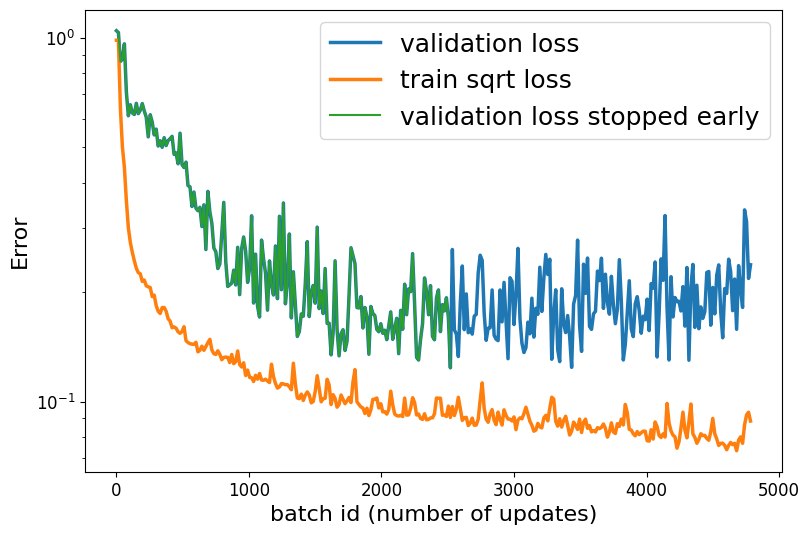

In [16]:
model.checkpoint_load_system('_last')
plt.figure(figsize=(9, 6))
plt.semilogy(model.batch_id,model.Loss_val, linewidth=2.5, label='validation loss') 

plt.semilogy(model.batch_id,model.Loss_train**0.5, linewidth=2.5, label='train sqrt loss')
plt.xlabel('batch id (number of updates)',fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('Error',fontsize=16)
plt.yticks(fontsize=12)
model.checkpoint_load_system('_best')
plt.semilogy(model.batch_id,model.Loss_val,label='validation loss stopped early')
plt.legend(fontsize=18)
plt.show()

In [43]:
train_sim = model.apply_experiment(train)
test_sim = model.apply_experiment(test)
val_sim = model.apply_experiment(val)


print('Main Results Cascaded tank:\n')

print(f'nx=2  RMS  train {train_sim.RMS(train):.7f}')
print(f'nx=2  RMS  val   {val_sim.RMS(val):.7f}')
print(f'nx=2  RMS  test  {test_sim.RMS(test):.7f}')

Main Results Cascaded tank:

nx=2  RMS  train 0.1703848
nx=2  RMS  val   0.2633250
nx=2  RMS  test  0.2793450


In [29]:
num_samples = 1024
start_time = 0
delta_t = 4
# Generate the series for t
t_series = [start_time + i * delta_t for i in range(num_samples)]

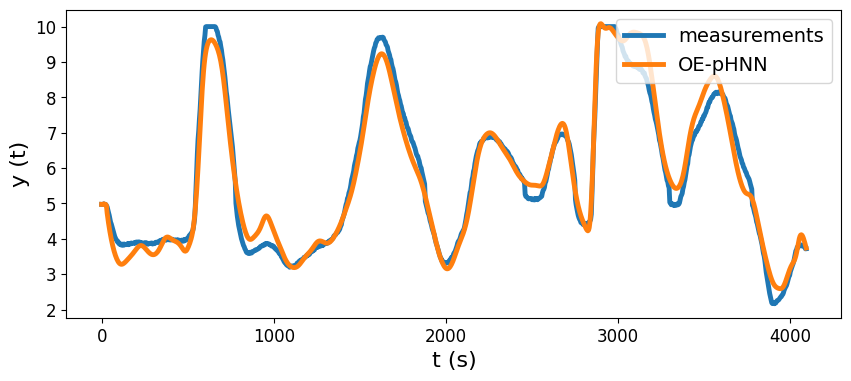

In [52]:
plt.figure(figsize=(10, 4))
plt.figure(1)
plt.plot(t_series,test.y[:],linewidth=3.5, label='measurements')
plt.plot(t_series,test_sim.y[:], linewidth=3.5, label='OE-pHNN')
plt.xlabel('t (s)',fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel('y (t)',fontsize=16)
plt.yticks(fontsize=12)
plt.legend(fontsize=14,loc='upper right')
# Save the plot as SVG
#plt.savefig("cascade_test.svg")